# Subreddit Stats

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as md
import numpy as np
import praw
from psaw import PushshiftAPI
import datetime
import yaml
import time
from sortedcontainers import SortedDict
from collections import OrderedDict

## Parameters

In [2]:
start_epoch = int(datetime.datetime(2018, 1, 1).timestamp())
start_subs = 680       # number of subs at start_epoch (needed if before 2018/3/15, see redditmetrics.com)
end_epoch = int(datetime.datetime(2019, 1, 1).timestamp())
max_posts = 10000      # max number of posts to crawl, None for unlimited
sub = 'dreamcatcher'   # subreddit to crawl

## Get Data

In [3]:
class Comment:
    def __init__(self):
        self.body = ''
        self.author = ''
        self.score = 0
        self.ts = 0
        self.url = ''

class Post:
    def __init__(self):
        self.title = ''
        self.author = ''
        self.ts = 0
        self.score = 0
        self.comments = []
        self.url = ''

In [4]:
stream = open('client_info.txt', 'r')
doc = yaml.load(stream)

r = praw.Reddit(client_id=doc['client_id'],
                client_secret=doc['client_secret'],
                user_agent='test'
                )
api_ps_praw = PushshiftAPI(r)
api_ps = PushshiftAPI()
post_ids = api_ps_praw.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['url', 'author', 'title', 'subreddit'],
                                  limit=max_posts)
subs = api_ps.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['subreddit', 'id', 'subreddit_subscribers'],
                                  limit=max_posts)
id2subs = {}

for s in subs:
    if hasattr(s, 'subreddit_subscribers'):
        num_subs = s.subreddit_subscribers
    else:
        num_subs = -1    
    id2subs[s.id] = num_subs
            
subcount = SortedDict()
posts = []
prev_info_len = 1

for i, post_id in enumerate(post_ids):
    submission = praw.models.Submission(r, id=post_id)
    ts = int(submission.created_utc)
    subcount[ts] = id2subs[post_id.id]
    submission.comments.replace_more()
    comment_ids = submission.comments.list()
    c = []
    
    for comment_id in comment_ids:
        comment = praw.models.Comment(r, id=comment_id)
        temp = Comment()
        temp.body = comment.body
        temp.author = comment.author
        temp.ts = comment.created_utc
        temp.score = comment.score
        temp.url = comment.permalink
        c.append(temp)
    
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    temp = Post()
    temp.title = submission.title
    temp.author = submission.author
    temp.ts = submission.created_utc
    temp.score = submission.score
    temp.comments = c
    temp.url = submission.permalink
    posts.append(temp)
    
    title = (temp.title[:47] + '...') if len(temp.title) > 47 else temp.title
    info = '%05d: %s --- %s' % (i, ts_str, title)
    clear = ' ' * prev_info_len
    print('%s' % clear, end='\r', flush=True)
    prev_info_len = len(info)
    print('%s' % info, end='\r', flush=True)
    
num_posts = i+1
    
print('\ndone')

03273: 2018-01-01 15:20:23 --- Dreamcatcher end of year awards                   ..
done


## Visualize Data

### Subscriber Growth

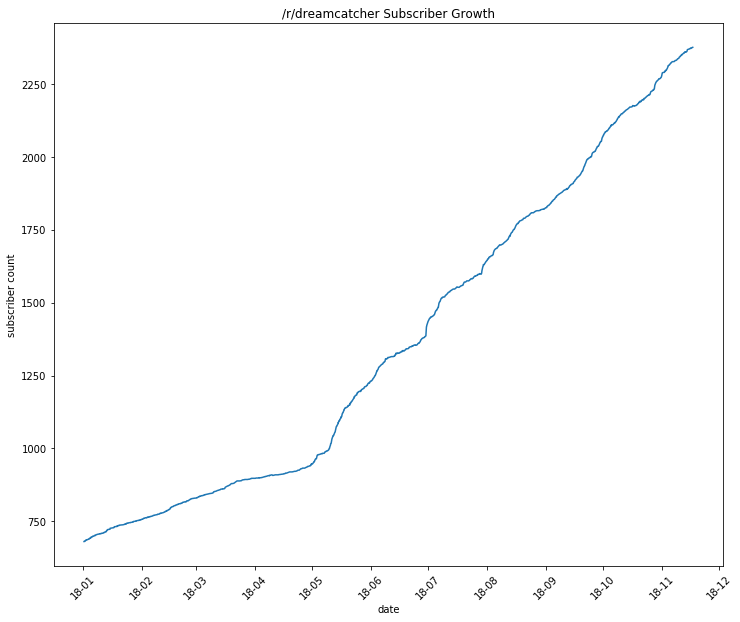

In [5]:
timestamps = np.zeros(len(subcount))
subs = np.zeros(len(subcount))
no_sub_data_end = -1
for i, ts in enumerate(subcount):
    timestamps[i] = ts
    subs[i] = subcount[ts]
    if subs[i] == -1:
        no_sub_data_end = i
        
    
if start_subs is not None:
    if no_sub_data_end < len(subs)-1:
        subs[:no_sub_data_end+1] = np.linspace(start_subs, subs[no_sub_data_end+1], no_sub_data_end+1)
        
for i in range(no_sub_data_end):
    subcount[timestamps[i]] = subs[i]
    
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, subs)
plt.xlabel('date')
plt.ylabel('subscriber count')
plt.title('/r/%s Subscriber Growth' % (sub))
plt.show()

### Top Posts

In [6]:
adj_scores = np.zeros((len(posts)), dtype=float)
for i, post in enumerate(posts):
    ts = int(post.ts)
    adj_scores[i] = (float(post.score) / subcount[ts])


top_idx = (-adj_scores).argsort()[:10]

for i, idx in enumerate(top_idx):
    post = posts[idx]
    ts = int(post.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top post #%d' % (i+1))
    print('title:          %s' % (post.title))
    print('author:         %s' % (post.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (post.score))
    print('adjusted score: %0.2f' % (float(post.score) / subcount[int(post.ts)]))
    print('comments:       %d' % (len(post.comments)))
    print('permalink:      https://www.reddit.com%s' % (post.url))
    print()

top post #1
title:          Dreamcatcher (드림캐쳐) - 'YOU AND I' MV
author:         SpideyCyclist
time:           2018-05-10 09:01:59
score:          172
adjusted score: 0.17
comments:       15
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8idh2r/dreamcatcher_드림캐쳐_you_and_i_mv/

top post #2
title:          New Fans Guide To Dreamcatcher
author:         SpideyCyclist
time:           2018-05-10 13:41:43
score:          125
adjusted score: 0.12
comments:       29
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8ieyin/new_fans_guide_to_dreamcatcher/

top post #3
title:          Dami, please..
author:         myblindy
time:           2018-05-11 15:08:56
score:          114
adjusted score: 0.11
comments:       7
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8ioh7t/dami_please/

top post #4
title:          Dreamcatcher (드림캐쳐) - 'What' MV
author:         SpideyCyclist
time:           2018-09-20 09:00:45
score:          189
adjusted score: 0.10
comm

### Top Comments

In [7]:
all_comments = []
comment_ts2post_ts = {}
for i, post in enumerate(posts):
    ts = int(post.ts)
    for comment in post.comments:
        all_comments.append(comment)
        if comment.ts not in comment_ts2post_ts:
            comment_ts2post_ts[comment.ts] = ts

adj_scores = np.zeros((len(all_comments)), dtype=float)
for i in range(len(all_comments)):
    ts = int(all_comments[i].ts)
    adj_scores[i] = float(all_comments[i].score) / subcount[comment_ts2post_ts[ts]]
    
top_idx = (-adj_scores).argsort()[:10]

for i, idx in enumerate(top_idx):
    comment = all_comments[idx]
    body = comment.body.replace('\n', ' ')
    body = (body[:97] + '...') if len(body) > 97 else body
    ts = int(comment.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top comment #%d' % (i+1))
    print('comment:        %s' % (body))
    print('author:         %s' % (comment.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (comment.score))
    print('adjusted score: %f' % (adj_scores[idx]))
    print('permalink:      https://www.reddit.com%s' % (comment.url))
    print()

top comment #1
comment:        Oh. My. God.   I made that jumper for her! Gave it to her in London!!! Freaking out a little bit....
author:         davefeeder
time:           2018-02-20 06:44:30
score:          21
adjusted score: 0.025989
permalink:      https://www.reddit.com/r/dreamcatcher/comments/7yttg6/yoohyeon_shark_doo_doo_doo_doo_doo_doo/duj5inx/

top comment #2
comment:        Hi everyone,  International fans \- this day is dedicated to you. After working tirelessly with H...
author:         DCUnion-Astraea
time:           2018-06-01 11:29:20
score:          31
adjusted score: 0.025183
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8nr4bi/eng_subs_available_on_dreamcatcher_videos/dzxndb0/

top comment #3
comment:        Everybody's rushing to check if she's okay while Gahyeon's busy laughing her ass off. This maknae...
author:         CDN_Datawraith
time:           2018-05-20 18:55:44
score:          21
adjusted score: 0.018293
permalink:      https://www.reddi

### Top Users

In [8]:
users = OrderedDict()
for i, post in enumerate(posts):
    ts = int(post.ts)
    if post.author == None:
        continue
    if post.author not in users:
        users[post.author] = {}
        users[post.author]['score'] = 0
        users[post.author]['adj_score'] = 0
        users[post.author]['posts'] = 0
        users[post.author]['comment_score'] = 0
        users[post.author]['adj_comment_score'] = 0
        users[post.author]['comments'] = 0
    users[post.author]['score'] += post.score
    users[post.author]['adj_score'] += (float(post.score) / subcount[ts])
    users[post.author]['posts'] += 1
    for comment in post.comments:
        if comment.author not in users:
            users[comment.author] = {}
            users[comment.author]['score'] = 0
            users[comment.author]['adj_score'] = 0
            users[comment.author]['posts'] = 0
            users[comment.author]['comment_score'] = 0
            users[comment.author]['adj_comment_score'] = 0
            users[comment.author]['comments'] = 0
        users[comment.author]['comment_score'] += comment.score
        users[comment.author]['adj_comment_score'] += (float(post.score) / subcount[ts])
        users[comment.author]['comments'] += 1

#### Top Posters

In [9]:
sorted_users = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_score'], reverse=True))

for i, key in enumerate(sorted_users):
    if i >= 10:
        break
    print('top poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('total number of posts: %d' % (sorted_users[key]['posts']))
    print('total score:           %d' % (sorted_users[key]['score']))
    print('total adjusted score:  %f' % (sorted_users[key]['adj_score']))
    print()

top poster #1
user:                  SpideyCyclist
total number of posts: 2341
total score:           62174
total adjusted score:  29.651179

top poster #2
user:                  myblindy
total number of posts: 71
total score:           3512
total adjusted score:  3.017245

top poster #3
user:                  CDN_Datawraith
total number of posts: 84
total score:           2403
total adjusted score:  1.441554

top poster #4
user:                  kyunikeon
total number of posts: 60
total score:           2357
total adjusted score:  1.156448

top poster #5
user:                  GenghisKhaii
total number of posts: 40
total score:           1186
total adjusted score:  0.730972

top poster #6
user:                  AmaryllisDC
total number of posts: 11
total score:           698
total adjusted score:  0.542775

top poster #7
user:                  davefeeder
total number of posts: 26
total score:           467
total adjusted score:  0.504465

top poster #8
user:                  Naienitsu

#### Top Commenters

In [10]:
sorted_users = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_comment_score'], reverse=True))

for i, key in enumerate(sorted_users):
    if i >= 10:
        break
    print('top commenter #%d' % (i+1))
    print('user:                          %s' % (key))
    print('total number of comments:      %d' % (sorted_users[key]['comments']))
    print('total comment score:           %d' % (sorted_users[key]['comment_score']))
    print('total adjusted comment score:  %f' % (sorted_users[key]['adj_comment_score']))
    print()

top commenter #1
user:                          SpideyCyclist
total number of comments:      2820
total comment score:           8042
total adjusted comment score:  65.285578

top commenter #2
user:                          internet0jesus
total number of comments:      944
total comment score:           4368
total adjusted comment score:  20.040902

top commenter #3
user:                          dreamcatcherERA
total number of comments:      342
total comment score:           1369
total adjusted comment score:  10.125841

top commenter #4
user:                          myblindy
total number of comments:      200
total comment score:           525
total adjusted comment score:  6.843140

top commenter #5
user:                          Darrens_Coconut
total number of comments:      244
total comment score:           1239
total adjusted comment score:  6.209981

top commenter #6
user:                          ipwnmice
total number of comments:      204
total comment score:           933
